In [1]:
import fenics as f
import matplotlib.pyplot as plt
from models import velocity_field, t_transport_sim, mesh_2d

----------  Running for dT=1 K  ----------*** Warning: Matplotlib plotting backend does not support mesh function of dim 1. Continuing without plotting...

Running for factor=1.0e-03
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 2.929e+04 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 3.930e-05 (tol = 1.000e-09) r (rel) = 1.342e-09 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.349e-09 (tol = 1.000e-09) r (rel) = 4.605e-14 (tol = 1.000e-09)
  Newton solver finished in 2 iterations and 2 linear solver iterations.
Running for factor=1.0e-02
No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 5.913e-09 (tol = 1.000e-09) r (rel) = 1.000e+00 (tol = 1.000e-09)
  New

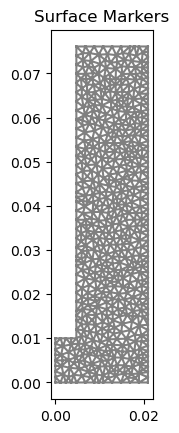

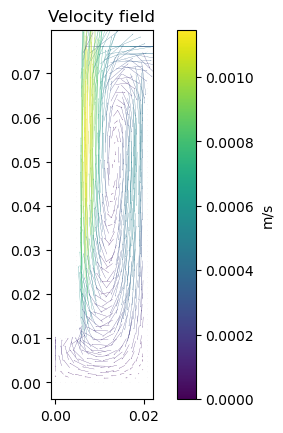

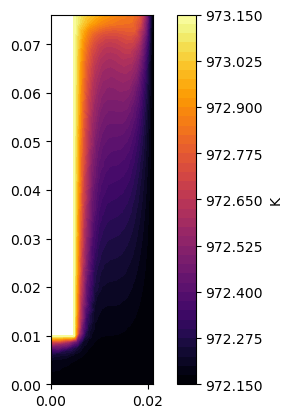

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Solving steady state problem...
Solved problem in 0.00 s


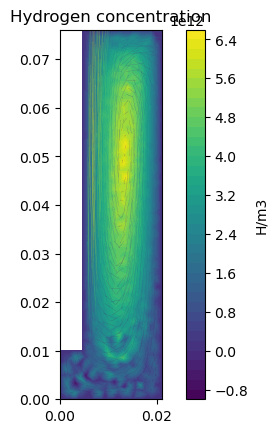

Total flux: 12413.118105557236 H/s/m
Average concentration: 2696279411355.522 H/m3
k: 3.734361188636825e-06 /s  (double check the units)


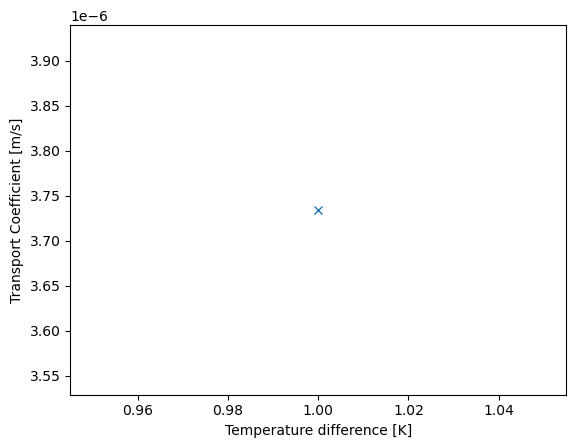

In [3]:
if __name__ == "__main__":
    # Generating mesh
    # x1 = 0.00476
    # x2 = 0.0162
    # y1 = 0.01
    # y2 = 0.0761
    # resolution = 30
    # mesh_fenics, surface_markers, left_id, top_id, right_id, bottom_id, upper_left_id, left_top_id = LMeshmshr(x1, x2, y1, y2, resolution)

    mesh_fenics, volume_markers, surface_markers, correspondance_dict = mesh_2d()

    T_hot = 700 + 273.15
    dt_array = [1]
    k_array = []
    for dT in dt_array:
        print(f"----------  Running for dT={dT} K  ----------")
        foldername = f"Results/dt={dT}/"
        T_cold = T_hot - dT
        u, p, T = velocity_field(
            T_cold=T_cold,
            T_hot=T_hot,
            my_mesh=mesh_fenics,
            surface_markers=surface_markers,
            correspondance_dict=correspondance_dict,
        )

        f.XDMFFile(foldername + "temperature_field.xdmf").write_checkpoint(
            T, "temperature", 1, f.XDMFFile.Encoding.HDF5
        )
        f.XDMFFile(foldername + "velocity_field.xdmf").write(u)

        plt.figure()
        plt.title("Velocity field")
        CS = f.plot(u, scale=1e-3)
        plt.colorbar(CS, label="m/s")
        plt.show()

        plt.figure()
        TS = f.plot(T, cmap="inferno")
        plt.colorbar(TS, label="K")
        plt.show()

        k = t_transport_sim(
            T,
            mesh_fenics,
            u,
            volume_markers=volume_markers,
            surface_markers=surface_markers,
            correspondance_dict=correspondance_dict,
        )
        k_array.append(k)

    plt.plot(dt_array, k_array, "-x", linewidth=3)
    plt.xlabel("Temperature difference [K]")
    plt.ylabel("Transport Coefficient [m/s]")

    # xdmf_file = XDMFFile("mesh_fencis.xdmf")
    # xdmf_file.write(mesh_fenics)
    # xdmf_file.close()